ResNet50 model 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm as notebook_tqdm
from datetime import datetime
import numpy as np 
import pandas as pd 

from PIL import Image
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from tqdm import tqdm
from PIL import Image
import torch
import torchvision
from torchvision.models.resnet import resnet50



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    torch.cuda.empty_cache()

/volumes1/thesis/notebooks/notebook_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

device(type='cuda')

In [3]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import DataLoader
import torchvision 
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torchvision import datasets 
from datetime import datetime

In [4]:
# defining hyperparameters  
epochs = 18
#epochs = 31   #the nn will train 31 times 
learning_rate = 0.0001 #how much the weight will be updated each time 
batch_size = 64 
classes = 43 
img_size = 32
random_seed = 42

In [5]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

In [6]:
def get_train_valid_loader(
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           num_workers=2):

    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg


    # load the dataset

    base_dataset = datasets.ImageFolder(
        root='/volumes1/thesis/notebooks/data/gtsrb/GTSRB/Training', transform=transforms,
    )

    # TODO
    split_datasets = torch.utils.data.random_split(base_dataset, [0.20,0.8])
    global val_dataset 
    val_dataset = split_datasets[0]
    train_dataset = split_datasets[1]
    

    global num_train 
    num_train= len(train_dataset)
    indices = list(range(num_train))
    global split 
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)


    #train_idx, valid_idx = indices[split:], indices[:split]
    #train_sampler = SubsetRandomSampler(train_idx)
    #valid_sampler = SubsetRandomSampler(valid_idx)


    global train_loader 
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = train_sampler
    )
    global valid_loader 
    valid_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size,
        num_workers=num_workers, 
        #sampler = valid_sampler
    )

    return train_loader, valid_loader

print(get_train_valid_loader(batch_size = 64, augment = True, random_seed = 1))


(<torch.utils.data.dataloader.DataLoader object at 0x7f2516ee9340>, <torch.utils.data.dataloader.DataLoader object at 0x7f247f778430>)


In [7]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [8]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    #plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [9]:
# train function

def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat= model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [10]:
# validation function, without a learning step (backward pass)

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat= model(X)    # predicted
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [11]:
# training function
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

In [12]:
model = resnet50(pretrained=False)
model.fc = torch.nn.Linear(2048,43)
model.conv1 = torch.nn.Conv2d(3,64,kernel_size=5,stride=1)

#model = model.to('cpu')
model = model.to(device)
model 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1):

In [13]:

torch.manual_seed(random_seed)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

12:34:21 --- Epoch: 0	Train loss: 2.6164	Valid loss: 1.6410	Train accuracy: 55.31	Valid accuracy: 51.45
12:34:55 --- Epoch: 1	Train loss: 1.0240	Valid loss: 0.6084	Train accuracy: 87.65	Valid accuracy: 81.46
12:35:29 --- Epoch: 2	Train loss: 0.3305	Valid loss: 0.3141	Train accuracy: 96.23	Valid accuracy: 90.35
12:36:02 --- Epoch: 3	Train loss: 0.0913	Valid loss: 0.2444	Train accuracy: 97.96	Valid accuracy: 92.74
12:36:36 --- Epoch: 4	Train loss: 0.0584	Valid loss: 0.2861	Train accuracy: 96.90	Valid accuracy: 90.99
12:37:10 --- Epoch: 5	Train loss: 0.0536	Valid loss: 0.2363	Train accuracy: 97.87	Valid accuracy: 93.21
12:37:44 --- Epoch: 6	Train loss: 0.0768	Valid loss: 0.3080	Train accuracy: 96.50	Valid accuracy: 91.63
12:38:17 --- Epoch: 7	Train loss: 0.1078	Valid loss: 0.2109	Train accuracy: 97.61	Valid accuracy: 94.13
12:38:51 --- Epoch: 8	Train loss: 0.0585	Valid loss: 0.1874	Train accuracy: 97.93	Valid accuracy: 95.05
12:39:26 --- Epoch: 9	Train loss: 0.0335	Valid loss: 0.1895	Trai

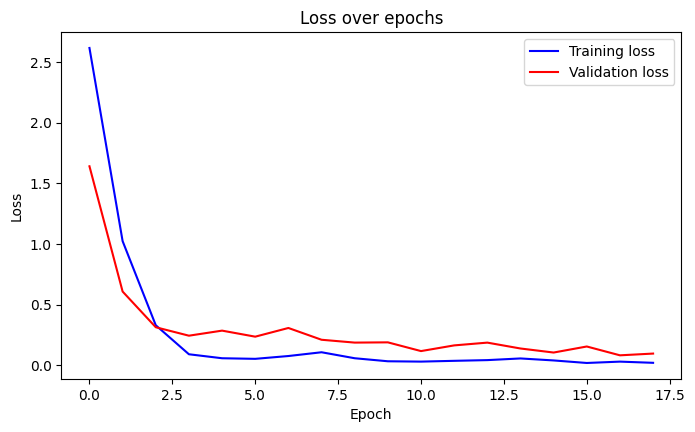

In [14]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device)

# evaluation 

In [17]:
parameters = (sum(p.numel() for p in model.parameters()))
parameters

23591595

In [19]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

23591595

In [15]:
from torchsummary import summary
print(summary(model, (3, 32, 32))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]           4,864
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]           4,096
       BatchNorm2d-6           [-1, 64, 14, 14]             128
              ReLU-7           [-1, 64, 14, 14]               0
            Conv2d-8           [-1, 64, 14, 14]          36,864
       BatchNorm2d-9           [-1, 64, 14, 14]             128
             ReLU-10           [-1, 64, 14, 14]               0
           Conv2d-11          [-1, 256, 14, 14]          16,384
      BatchNorm2d-12          [-1, 256, 14, 14]             512
           Conv2d-13          [-1, 256, 14, 14]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
print("Model's state dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print("")

In [ ]:
from torchsummary import summary
print(summary(model, (3, 32, 32))) 

In [ ]:

test_dataset = torchvision.datasets.GTSRB(
    root='./data', split = 'test', transform=transforms, download=True)

# train loader 
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size
, shuffle=False, num_workers=2)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 



In [ ]:
model.to('cpu')

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
# constant for classes
classes = ( '0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
# df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (40,15))
# sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')


# print(cf_matrix)
# cf_report = classification_report(y_true, y_pred)
# print(cf_report)

In [ ]:
def get_classification_report(y_test, y_pred):
    '''Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format'''
    from sklearn import metrics
    report = metrics.classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
    return df_classification_report


get_classification_report(y_test = y_true, y_pred = y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, recall_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))
print('Micro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))
print('Macro Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))
print('Weighted Sensitivity: {:.2f}\n'.format(recall_score(y_true, y_pred, average='weighted')))

In [ ]:
cf_report(y_true, y_pred, zero_division = 0, target_names=['0:Speed limit (20km/h)',
            '1:Speed limit (30km/h)', 
            '2:Speed limit (50km/h)', 
            '3:Speed limit (60km/h)', 
            '4:Speed limit (70km/h)', 
            '5:Speed limit (80km/h)', 
            '6:End of speed limit (80km/h)', 
            '7:Speed limit (100km/h)', 
            '8:Speed limit (120km/h)', 
            '9:No passing', 
            '10:No passing veh over 3.5 tons', 
            '11:Right-of-way at intersection', 
            '12:Priority road', 
            '13:Yield', 
            '14:Stop', 
            '15:No vehicles', 
            '16:Veh > 3.5 tons prohibited', 
            '17:No entry', 
            '18:General caution', 
            '19:Dangerous curve left', 
            '20:Dangerous curve right', 
            '21:Double curve', 
            '22:Bumpy road', 
            '23:Slippery road', 
            '24:Road narrows on the right', 
            '25:Road work', 
            '26:Traffic signals', 
            '27:Pedestrians', 
            '28:Children crossing', 
            '29:Bicycles crossing', 
            '30:Beware of ice/snow',
            '31:Wild animals crossing', 
            '32:End speed + passing limits', 
            '33:Turn right ahead', 
            '34:Turn left ahead', 
            '35:Ahead only', 
            '36:Go straight or right', 
            '37:Go straight or left', 
            '38:Keep right', 
            '39:Keep left', 
            '40:Roundabout mandatory', 
            '41:End of no passing', 
            '42:End no passing veh > 3.5 tons']))
print(cf_report)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sn 
model.to('cpu')

In [ ]:
print(cf_matrix)

In [ ]:
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (40,15))
sn.heatmap(df_cm, annot=True)
plt.savefig('Resnet50.png')

In [ ]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):
    classes = []
    plotMat = []

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
multilabel_confusion_matrix(y_true, y_pred) 


In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import PyTorchClassifier

# FGSM Attack 

In [ ]:
X, y = test_dataset[0]
X.shape, X.min(), X.max()

# class NormalizeInverse(torchvision.transforms.Normalize):
#     """
#     Undoes the normalization and returns the reconstructed images in the input domain.
#     """

#     def __init__(self, mean, std):
#         mean = torch.as_tensor(mean)
#         std = torch.as_tensor(std)
#         std_inv = 1 / (std + 1e-7)
#         mean_inv = -mean * std_inv
#         super().__init__(mean=mean_inv, std=std_inv)

#     def __call__(self, tensor):
#         return super().__call__(tensor.clone())


# inverse_normalize = NormalizeInverse(mean=(0.3403, 0.3121, 0.3214), std=(0.2724, 0.2608, 0.2669))  # Same mean and std values as defined in the original transforms.
# #torchvision.transforms.ToPILImage()((X))

class WrappedModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.trained_model = model  # "model" is our trained model
    self.trained_model.to("cpu")
    self.normalize = torchvision.transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))

  def forward(self, x: torch.Tensor):
    # x comes in as a Tensor of shape [3, 32, 32]
    # Manually add a batch dimension
    x = torch.unsqueeze(x, dim=0)
    # Shape of x is now [1, 3, 32, 32]
    # Normalize the input
    x_normalized = self.normalize(x)
    # Return only the logits
    logits = self.trained_model(x_normalized)
    return logits

# We again wrap our (already wrapped) model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
      model=WrappedModel(),
      clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
      loss=criterion,  # defined above
      optimizer=optimizer,  # defined above
      input_shape=(3, 32, 32),
      nb_classes=43,
      device_type="cpu"
)

attack = FastGradientMethod(estimator=classifier, eps=0.1)
# benign_x = inverse_normalize(X)
benign_x = X.cpu().numpy()  # convert torch to numpy
type(benign_x), benign_x.min(), benign_x.max()
x_adversarial = attack.generate(benign_x)

In [ ]:
import os 
#path = "/volumes1/thesis/data/gtsrb/Adv_samples_resnet50_fgsm"
#os.mkdir(path)
test_model = WrappedModel()
attack = FastGradientMethod(estimator=classifier, eps=0.1)
for i, (x, y_true) in enumerate(test_dataset):
    benign_x = x.cpu().numpy()
    y_predicted = torch.argmax(test_model(torch.Tensor(benign_x)))
    if y_predicted == y_true:
        x_adversarial = attack.generate(benign_x)
        y_adversarial = torch.argmax(test_model(torch.Tensor(x_adversarial)))
        if y_adversarial != y_predicted:
            np.save(f"{path}/adv_samples_resnet50_fgsm_sample_{i}", x_adversarial)
    else:
        print('failed')

# CW Attack

In [ ]:
from art.attacks.evasion import CarliniL0Method, CarliniL2Method, CarliniLInfMethod
from torchvision.datasets import GTSRB
from art.estimators.classification import PyTorchClassifier

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.trained_model = model  # "model" is our trained model
        self.trained_model.to("cpu")
        self.normalize = torchvision.transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
    def forward(self, x: torch.Tensor):
        # x comes in as a Tensor of shape [1, 3, 32, 32] (same as the input size passed to attack.generate())
        # Normalize the input
        x_normalized = self.normalize(x)
        # Return only the logits
        logits = self.trained_model(x_normalized)
        return logits


optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
wrapped_model = WrappedModel(model)
normalize = torchvision.transforms.Normalize((0.3403, 0.3121, 0.3214), (0.2724, 0.2608, 0.2669))
# We again wrap our (already wrapped) model in a PyTorchClassifier, which ART knows how to use
classifier = PyTorchClassifier(
    model=wrapped_model,
    # model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
    channels_first=True,
)
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor()]
)

test_dataset = GTSRB(root="data", split="test", transform=transforms, download=True)
x, y_true = test_dataset[0]
# cw0_attack = CarliniL0Method(classifier, learning_rate=0.0001)
# l2_attack = CarliniL2Method(classifier, learning_rate=0.0001)
# linf_attack = CarliniLInfMethod(classifier, learning_rate=0.0001)
# art_input = np.expand_dims(x.numpy(), axis=0)
# adv_samples = cw0_attack.generate(art_input)
# adv_samples = l2_attack.generate(art_input)
# adv_samples = linf_attack.generate(art_input)


In [ ]:
tested_model = wrapped_model.to('cpu')
tested_model

In [ ]:
import os 
path = "/volumes1/thesis/data/gtsrb/Adv_samples_resnet50_fgsm"
os.mkdir(path)
for i, (x, y_true) in enumerate(test_dataset):
    attack = FastGradientMethod(estimator=classifier, eps=0.1)
    benign_x = x.cpu().numpy()
    test_model = WrappedModel()
    y_predicted = torch.argmax(test_model(torch.Tensor(benign_x)))
    #type(benign_x), benign_x.min(), benign_x.max()
    if y_predicted == y_true:
        x_adversarial = attack.generate(benign_x)
        y_adversarial = torch.argmax(test_model(torch.Tensor(x_adversarial)))
        if y_adversarial != y_predicted:
            np.save(f"{path}/adv_samples_resnet50_fgsm_sample_{i}", x_adversarial)
    else:
        print('failed')

In [ ]:
#path = "/volumes1/thesis/data/gtsrb/adv_samples_resnet50_l2"
#os.mkdir(path)
l2_attack = CarliniL2Method(classifier, learning_rate=0.0001)
for i, (x, y_true) in enumerate(test_dataset):
    art_input = np.expand_dims(x.numpy(), axis=0)
    y_predicted = torch.argmax(tested_model(torch.Tensor(art_input)))
    if y_predicted == y_true:
        adv_samples = l2_attack.generate(art_input) 
        y_adversarial = torch.argmax(tested_model(torch.Tensor(adv_samples)))
        if y_adversarial != y_predicted:
            np.save(f"{path}/adv_samples_resnet50_l2_sample_{i}", adv_samples)
        else: 
            print('failed')

In [ ]:
path = "/volumes1/thesis/data/gtsrb/adv_samples_resnet50_linf"
os.mkdir(path)
linf_attack = CarliniLInfMethod(classifier, learning_rate=0.0001)
for i, (x, y_true) in enumerate(test_dataset):
    art_input = np.expand_dims(x.numpy(), axis=0)
    y_predicted = torch.argmax(tested_model(torch.Tensor(art_input)))
    if y_predicted == y_true:
        adv_samples = linf_attack.generate(art_input) 
        y_adversarial = torch.argmax(tested_model(torch.Tensor(adv_samples)))
        if y_adversarial != y_predicted:
            np.save(f"{path}/adv_samples_resnet50_linf_sample_{i}", adv_samples)
        else: 
            print('failed')

# Training 


In [ ]:
import numpy as np 
from PIL import Image   

In [ ]:
for i, (x, y) in enumerate(/volumes1/thesis/data/gtsrb/Adv_samples_resnet50_fgsm):
    img_array = np.load("/adv_samples_resnet50_fgsm_sample_{i}")
    img_array = np.moveaxis(img_array, 0, 2)
    img_array = (img_array * 255).astype(np.uint8)
    img = Image.fromarray(img_array, "RGB")


In [ ]:
from pathlib import Path 

In [ ]:
Path('Adv_samples_resnet50_fgsm').absolute()

In [ ]:
def npy_loader(path):
    return torch.from_numpy(np.load(path))

In [ ]:

def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    img_array = np.moveaxis(sample, 0, 2)
    img_array = (img_array * 255).astype(np.uint8)
    img = Image.fromarray(img_array, "RGB")
    return img
    
dataset = datasets.DatasetFolder(
    root='/volumes1/thesis/data/gtsrb/Adv_samples_resnet50_fgsm',
    loader=npy_loader,
    extensions=['.npy']
)

In [ ]:
from torchvision.datasets import DatasetFolder
from torchvision import find_classes

In [ ]:
find_classes('/volumes1/thesis/data/gtsrb/Adv_samples_resnet50_fgsm')

In [ ]:
dataset = datasets.ImageFolder(
    root='/volumes1/thesis/data/gtsrb/Adv_samples_resnet50_fgsm',
    loader=npy_loader,
    extensions=['.npy']
)

In [ ]:
import os

import torch
import torch.optim as optim
import numpy as np

from torch import nn
from sklearn.utils import shuffle

from art.estimators.certification import deep_z
from art.utils import to_categorical

In [ ]:
classifier = PyTorchClassifier(
    model=wrapped_model,
    # model=model,
    clip_values=(0.0, 1.0),  # The adversarial sample tensor values will be within these values
    loss=criterion,  # defined above
    optimizer=optimizer,  # defined above
    input_shape=(3, 32, 32),
    nb_classes=43,
    device_type="cpu",
    channels_first=True,
)

In [ ]:
model.to('cpu')

In [ ]:
print(optimizer, criterion) 